In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import ot
import networkx as nx
import matplotlib.pyplot as plt

from ot.gromov import gromov_wasserstein as GW
from ot.utils import unif

from utils.gw_ms import gw_ms_couple_nu
from utils.utils_ms import cost_ms_couple_nu

import random
import itertools
import networkx as nx

# Path to save figures
from pathlib import Path

folder_figs = "figures"

# Functions

In [3]:
def random_coupling(p, q, rng, random_init_iter=10):
    R = rng.random((p.size, q.size))
    for _ in range(random_init_iter):
        R *= (p / R.sum(axis=1))[:, None]
        R *= (q / R.sum(axis=0))[None, :]
    return R


# Multiple runs of standard GW with random initial coupling, keep the best result
def GW_random(
    C1,
    C2,
    p=None,
    q=None,
    random_reps=1,
    random_seed=None,
    random_init_iter=10,
    loss_fun="square_loss",
    symmetric=None,
    log=False,
    armijo=False,
    max_iter=1e4,
    tol_rel=1e-9,
    tol_abs=1e-9,
    **kwargs,
):
    cost_best = np.inf
    T_best = None
    log_best = None

    # Set RNG object for reproducibility
    rng = np.random.default_rng(random_seed)

    # Repeat GW with multiple random initializations
    for _ in range(random_reps):
        G0 = random_coupling(p, q, rng=rng, random_init_iter=random_init_iter)

        T, log_0 = GW(
            C1,
            C2,
            p=p,
            q=q,
            G0=G0,
            loss_fun=loss_fun,
            symmetric=symmetric,
            log=True,
            armijo=armijo,
            max_iter=max_iter,
            tol_rel=tol_rel,
            tol_abs=tol_abs,
            **kwargs,
        )

        cost = log_0["gw_dist"]
        if cost < cost_best:
            cost_best = cost
            T_best = T
            log_best = log_0

    if log:
        return T_best, cost_best, log_best
    else:
        return T_best, cost_best


# Multiple runs of parametrized GW with random initial coupling (on spaces, not parameters)
# and keep the best result
def gw_ms_couple_nu_random(
    lC1,
    lC2,
    p=None,
    q=None,
    nu1=None,
    nu2=None,
    E0=None,
    random_reps=1,
    random_seed=None,
    random_init_iter=10,
    loss_fun="square_loss",
    max_iter=1e4,
    log=False,
    **kwargs,
):
    cost_best = np.inf
    T_best = None
    E_best = None
    log_best = None

    # Set RNG object for reproducibility
    rng = np.random.default_rng(random_seed)

    # Repeat gw_ms_couple_nu with multiple random initializations
    for _ in range(random_reps):
        # Select a random initial coupling
        G0 = random_coupling(p, q, rng=rng, random_init_iter=random_init_iter)

        T, E, log_0, _, _ = gw_ms_couple_nu(
            lC1,
            lC2,
            p=p,
            q=q,
            G0=G0,
            E0=E0,
            nu1=nu1,
            nu2=nu2,
            loss_fun=loss_fun,
            log=True,
            max_iter=max_iter,
            **kwargs,
        )

        # Keep the coupling with lowest cost
        cost = log_0["loss"][-1]
        if cost < cost_best:
            cost_best = cost
            T_best = T
            E_best = E
            log_best = log_0

    if log:
        return T_best, E_best, cost_best, log_best
    else:
        return T_best, E_best, cost_best

In [4]:
def perturb_graph_edges(G, k: int, m: int, seed: int = None) -> nx.Graph:
    """
    Return a copy of G with k random edges removed and m random non‐existing edges added.

    Parameters
    ----------
    G : networkx.Graph
        The original graph (undirected).
    k : int
        Number of edges to remove. If k > |E(G)|, all edges will be removed.
    m : int
        Number of edges to add. If m > number of possible new edges, as many as possible are added.
    seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    G_new : networkx.Graph
        A new graph with k edges removed and m edges added.
    """
    if seed is not None:
        random.seed(seed)

    # Work on a copy
    G_new = G.copy()

    # 1) Remove k random edges
    existing_edges = list(G_new.edges())
    k_remove = min(k, len(existing_edges))
    edges_to_remove = random.sample(existing_edges, k_remove)
    G_new.remove_edges_from(edges_to_remove)

    # 2) Build list of all possible new edges (undirected, no self‐loops)
    nodes = list(G_new.nodes())
    existing = set(map(lambda e: tuple(sorted(e)), G_new.edges()))
    all_pairs = itertools.combinations(nodes, 2)
    possible_new = [pair for pair in all_pairs if pair not in existing]

    # 3) Add m random new edges
    m_add = min(m, len(possible_new))
    edges_to_add = random.sample(possible_new, m_add)
    G_new.add_edges_from(edges_to_add)

    return G_new

# Experiment

Idea: for given numbers of deletions and additions (which we will vary in the experiment), we:
- create two datasets of n graphs, for n = 1, 10, 20, 50, 100
- compute multiscale GW distance
- compute pairwise (standard) GW distances and average the result
- run the above 10 times and average the results

In [5]:
G = nx.Graph()
G.add_nodes_from(list(range(9)))
G.add_edges_from(
    [
        (0, 1),
        (0, 2),
        (1, 2),
        (1, 3),
        (2, 5),
        (3, 4),
        (4, 5),
        (5, 7),
        (5, 8),
        (6, 7),
        (7, 8),
    ]
)

In [6]:
kernel = "adjacency"
mu0 = ot.unif(len(G))
mu1 = ot.unif(len(G))
num_trials = 10
ns = [1, 10, 20, 50, 100]
random_reps = 20
random_init_iter = 10

################################

num_del_add = 2

num_del0 = num_del_add
num_add0 = num_del_add

num_del1 = num_del_add
num_add1 = num_del_add

scores_multiscale = []
scores_gw = []

###############################

for n in ns:
    n0 = n
    n1 = n

    ###############################

    trial_scores_multiscale = []
    trial_scores_gw = []

    for ii in range(num_trials):

        S0 = []
        S1 = []

        nu0 = ot.unif(n0)
        nu1 = ot.unif(n1)

        if kernel == "distance":
            for j in range(n0):
                connected_flag = False
                while connected_flag == False:
                    G_new = perturb_graph_edges(G, num_del0, num_add0)
                    connected_flag = True
                    if connected_flag:
                        S0.append(nx.floyd_warshall_numpy(G_new))

            for j in range(n1):
                connected_flag = False
                while connected_flag == False:
                    G_new = perturb_graph_edges(G, num_del1, num_add1)
                    connected_flag = nx.is_connected(G_new)
                    if connected_flag:
                        S1.append(nx.floyd_warshall_numpy(G_new))

        if kernel == "adjacency":
            for j in range(n0):
                G_new = perturb_graph_edges(G, num_del0, num_add0)
                S0.append(nx.to_numpy_array(G_new))

            for j in range(n1):
                G_new = perturb_graph_edges(G, num_del1, num_add1)
                S1.append(nx.to_numpy_array(G_new))

        T, Q, cost = gw_ms_couple_nu_random(
            S0,
            S1,
            mu0,
            mu1,
            random_seed=42,
            random_reps=random_reps,
            random_init_iter=random_init_iter,
            verbose=False,
        )

        trial_scores_gw_trial = []

        for jj in range(n):
            T_best, cost_best = GW_random(
                S0[jj],
                S1[jj],
                p=mu0,
                q=mu1,
                loss_fun="square_loss",
                random_seed=42,
                random_reps=random_reps,
                random_init_iter=random_init_iter,
                max_iter=200,
                tol_rel=1e-6,
            )

            trial_scores_gw_trial.append(cost_best)

        trial_scores_gw.append(np.mean(trial_scores_gw_trial))
        trial_scores_multiscale.append(cost)

    scores_multiscale.append(trial_scores_multiscale)
    scores_gw.append(trial_scores_gw)
    print(n)

1
10
20
50
100


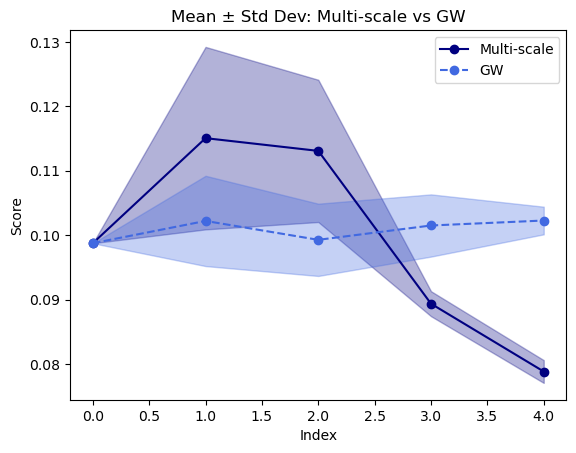

In [7]:
# Compute means and standard deviations
means_ms = np.array([np.mean(s) for s in scores_multiscale])
stds_ms = np.array([np.std(s) for s in scores_multiscale])
means_gw = np.array([np.mean(s) for s in scores_gw])
stds_gw = np.array([np.std(s) for s in scores_gw])

x = np.arange(len(means_ms))

# Define two similar but distinct colors
color1 = "navy"
color2 = "royalblue"

plt.figure()
# Multi-scale: solid line + shaded region
plt.plot(x, means_ms, "o-", label="Multi-scale", color=color1)
plt.fill_between(x, means_ms - stds_ms, means_ms + stds_ms, alpha=0.3, color=color1)

# GW: dashed line + shaded region
plt.plot(x, means_gw, "o--", label="GW", color=color2)
plt.fill_between(x, means_gw - stds_gw, means_gw + stds_gw, alpha=0.3, color=color2)

plt.xlabel("Index")
plt.ylabel("Score")
plt.title("Mean ± Std Dev: Multi-scale vs GW")
plt.legend()
plt.show()

In [8]:
kernel = "adjacency"
mu0 = ot.unif(len(G))
mu1 = ot.unif(len(G))
num_trials = 10
ns = [1, 10, 20, 50, 100]
random_reps = 10
random_init_iter = 10

################################

num_del_adds = [1, 2, 3]

all_scores_multiscale = []
all_scores_gw = []

for num_del_add in num_del_adds:

    num_del0 = num_del_add
    num_add0 = num_del_add

    num_del1 = num_del_add
    num_add1 = num_del_add

    scores_multiscale = []
    scores_gw = []

    ###############################

    for n in ns:

        n0 = n
        n1 = n

        ###############################

        trial_scores_multiscale = []
        trial_scores_gw = []

        for ii in range(num_trials):

            S0 = []
            S1 = []

            nu0 = ot.unif(n0)
            nu1 = ot.unif(n1)

            if kernel == "distance":
                for j in range(n0):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G, num_del0, num_add0)
                        connected_flag = True
                        if connected_flag:
                            S0.append(nx.floyd_warshall_numpy(G_new))

                for j in range(n1):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G, num_del1, num_add1)
                        connected_flag = nx.is_connected(G_new)
                        if connected_flag:
                            S1.append(nx.floyd_warshall_numpy(G_new))

            if kernel == "adjacency":
                for j in range(n0):
                    G_new = perturb_graph_edges(G, num_del0, num_add0)
                    S0.append(nx.to_numpy_array(G_new))

                for j in range(n1):
                    G_new = perturb_graph_edges(G, num_del1, num_add1)
                    S1.append(nx.to_numpy_array(G_new))

            T, Q, cost = gw_ms_couple_nu_random(
                S0,
                S1,
                mu0,
                mu1,
                random_seed=42,
                random_reps=random_reps,
                random_init_iter=random_init_iter,
                verbose=False,
            )

            trial_scores_gw_trial = []

            for jj in range(n):
                T_best, cost_best = GW_random(
                    S0[jj],
                    S1[jj],
                    p=mu0,
                    q=mu1,
                    loss_fun="square_loss",
                    random_seed=42,
                    random_reps=random_reps,
                    random_init_iter=random_init_iter,
                    max_iter=200,
                    tol_rel=1e-6,
                )

                trial_scores_gw_trial.append(cost_best)

            trial_scores_gw.append(np.mean(trial_scores_gw_trial))
            trial_scores_multiscale.append(cost)

        scores_multiscale.append(trial_scores_multiscale)
        scores_gw.append(trial_scores_gw)
        print("n", n)

    all_scores_multiscale.append(scores_multiscale)
    all_scores_gw.append(scores_gw)

    print("del_add", num_del_add)

n 1
n 10
n 20
n 50
n 100
del_add 1
n 1
n 10
n 20
n 50
n 100
del_add 2
n 1
n 10
n 20
n 50
n 100
del_add 3


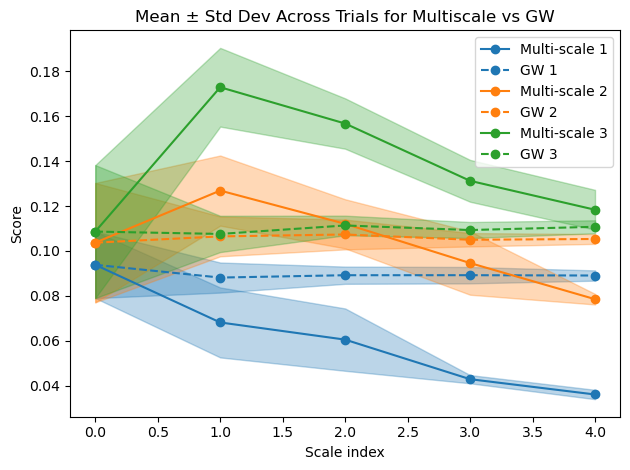

In [9]:
# Colormap for distinct colors
cmap = plt.get_cmap("tab10")
n_plots = len(all_scores_multiscale)
colors = [cmap(i) for i in range(n_plots)]

x = np.arange(len(all_scores_multiscale[0]))

plt.figure()
for idx, (scores_ms, scores_gw) in enumerate(zip(all_scores_multiscale, all_scores_gw)):
    # Compute statistics
    means_ms = np.array([np.mean(s) for s in scores_ms])
    stds_ms = np.array([np.std(s) for s in scores_ms])
    means_gw = np.array([np.mean(s) for s in scores_gw])
    stds_gw = np.array([np.std(s) for s in scores_gw])

    color = colors[idx]
    # Multi-scale: solid
    plt.plot(x, means_ms, "o-", color=color, label=f"Multi-scale {idx+1}")
    plt.fill_between(x, means_ms - stds_ms, means_ms + stds_ms, alpha=0.3, color=color)
    # GW: dashed
    plt.plot(x, means_gw, "o--", color=color, label=f"GW {idx+1}")
    plt.fill_between(x, means_gw - stds_gw, means_gw + stds_gw, alpha=0.3, color=color)

plt.xlabel("Scale index")
plt.ylabel("Score")
plt.title("Mean ± Std Dev Across Trials for Multiscale vs GW")
plt.legend()
plt.tight_layout()
plt.show()

## Karate Club

Running the same experiment on the 'Karate Club' Graph. The hope is that, for a bigger graph, the benefits of the multiscale approach will be more pronounced.

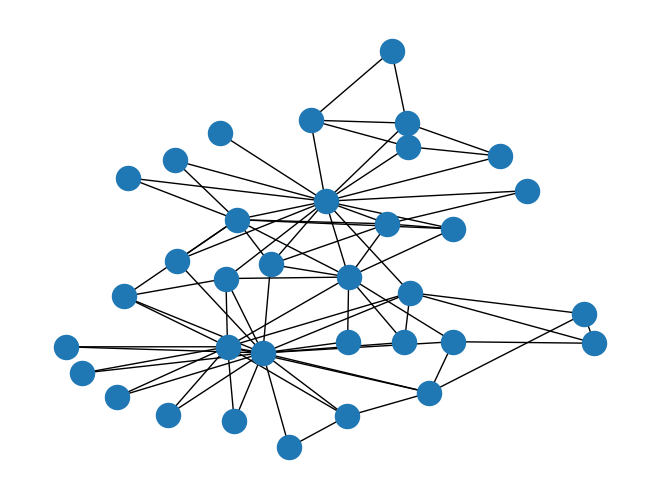

In [44]:
G_weighted = nx.karate_club_graph()
G = nx.Graph()
G.add_nodes_from(G_weighted.nodes())
G.add_edges_from(G_weighted.edges())
pos = nx.kamada_kawai_layout(G)
nx.draw_kamada_kawai(G)

In [45]:
kernel = "adjacency"
mu0 = ot.unif(len(G))
mu1 = ot.unif(len(G))
num_trials = 10
ns = [1, 10, 20, 50, 100]
random_reps = 10
random_init_iter = 10

################################

num_del_adds = [1, 2, 3]

all_scores_multiscale = []
all_scores_gw = []

for num_del_add in num_del_adds:

    num_del0 = num_del_add
    num_add0 = num_del_add

    num_del1 = num_del_add
    num_add1 = num_del_add

    scores_multiscale = []
    scores_gw = []

    ###############################

    for n in ns:

        n0 = n
        n1 = n

        ###############################

        trial_scores_multiscale = []
        trial_scores_gw = []

        for ii in range(num_trials):

            S0 = []
            S1 = []

            nu0 = ot.unif(n0)
            nu1 = ot.unif(n1)

            if kernel == "distance":
                for j in range(n0):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G, num_del0, num_add0)
                        connected_flag = True
                        if connected_flag:
                            S0.append(nx.floyd_warshall_numpy(G_new))

                for j in range(n1):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G, num_del1, num_add1)
                        connected_flag = nx.is_connected(G_new)
                        if connected_flag:
                            S1.append(nx.floyd_warshall_numpy(G_new))

            if kernel == "adjacency":
                for j in range(n0):
                    G_new = perturb_graph_edges(G, num_del0, num_add0)
                    S0.append(nx.to_numpy_array(G_new))

                for j in range(n1):
                    G_new = perturb_graph_edges(G, num_del1, num_add1)
                    S1.append(nx.to_numpy_array(G_new))

            T, Q, cost = gw_ms_couple_nu_random(
                S0,
                S1,
                mu0,
                mu1,
                random_seed=42,
                random_reps=random_reps,
                random_init_iter=random_init_iter,
                verbose=False,
            )

            trial_scores_gw_trial = []

            for jj in range(n):
                T_best, cost_best = GW_random(
                    S0[jj],
                    S1[jj],
                    p=mu0,
                    q=mu1,
                    loss_fun="square_loss",
                    random_seed=42,
                    random_reps=random_reps,
                    random_init_iter=random_init_iter,
                    max_iter=200,
                    tol_rel=1e-6,
                )

                trial_scores_gw_trial.append(cost_best)

            trial_scores_gw.append(np.mean(trial_scores_gw_trial))
            trial_scores_multiscale.append(cost)

        scores_multiscale.append(trial_scores_multiscale)
        scores_gw.append(trial_scores_gw)
        print("n", n)

    all_scores_multiscale.append(scores_multiscale)
    all_scores_gw.append(scores_gw)

    print("del_add", num_del_add)

n 1
n 10
n 20
n 50
n 100
del_add 1
n 1
n 10
n 20
n 50
n 100
del_add 2
n 1
n 10
n 20
n 50
n 100
del_add 3


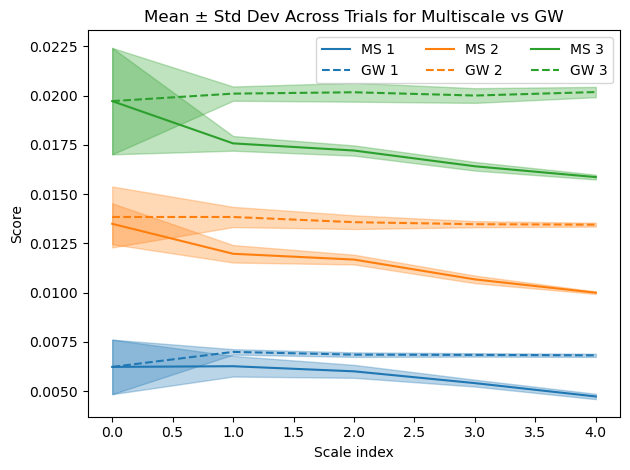

In [46]:
# Colormap for distinct colors
cmap = plt.get_cmap("tab10")
n_plots = len(all_scores_multiscale)
colors = [cmap(i) for i in range(n_plots)]

x = np.arange(len(all_scores_multiscale[0]))

plt.figure()
for idx, (scores_ms, scores_gw) in enumerate(zip(all_scores_multiscale, all_scores_gw)):
    # Compute statistics
    means_ms = np.array([np.mean(s) for s in scores_ms])
    stds_ms = np.array([np.std(s) for s in scores_ms])
    means_gw = np.array([np.mean(s) for s in scores_gw])
    stds_gw = np.array([np.std(s) for s in scores_gw])

    color = colors[idx]
    # Multi-scale: solid
    plt.plot(x, means_ms, "-", color=color, label=f"MS {idx+1}")
    plt.fill_between(x, means_ms - stds_ms, means_ms + stds_ms, alpha=0.3, color=color)
    # GW: dashed
    plt.plot(x, means_gw, "--", color=color, label=f"GW {idx+1}")
    plt.fill_between(x, means_gw - stds_gw, means_gw + stds_gw, alpha=0.3, color=color)

plt.xlabel("Scale index")
plt.ylabel("Score")
plt.title("Mean ± Std Dev Across Trials for Multiscale vs GW")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()

In [47]:
kernel = "adjacency"
mu0 = ot.unif(len(G))
mu1 = ot.unif(len(G))
num_trials = 10
ns = [1, 10, 20, 50, 100]
# ns = [1, 10]
random_reps = 20
random_init_iter = 10

################################

num_del_adds = [1, 2, 3, 4, 5]

all_scores_multiscale = []
all_scores_gw = []

for num_del_add in num_del_adds:

    num_del0 = num_del_add
    num_add0 = num_del_add

    num_del1 = num_del_add
    num_add1 = num_del_add

    scores_multiscale = []
    scores_gw = []

    ###############################

    for n in ns:

        n0 = n
        n1 = n

        ###############################

        trial_scores_multiscale = []
        trial_scores_gw = []

        for ii in range(num_trials):

            S0 = []
            S1 = []

            nu0 = ot.unif(n0)
            nu1 = ot.unif(n1)

            if kernel == "distance":
                for j in range(n0):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G, num_del0, num_add0)
                        connected_flag = True
                        if connected_flag:
                            S0.append(nx.floyd_warshall_numpy(G_new))

                for j in range(n1):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G, num_del1, num_add1)
                        connected_flag = nx.is_connected(G_new)
                        if connected_flag:
                            S1.append(nx.floyd_warshall_numpy(G_new))

            if kernel == "adjacency":
                for j in range(n0):
                    G_new = perturb_graph_edges(G, num_del0, num_add0)
                    S0.append(nx.to_numpy_array(G_new))

                for j in range(n1):
                    G_new = perturb_graph_edges(G, num_del1, num_add1)
                    S1.append(nx.to_numpy_array(G_new))

            T, Q, cost = gw_ms_couple_nu_random(
                S0,
                S1,
                mu0,
                mu1,
                random_seed=42,
                random_reps=random_reps,
                random_init_iter=random_init_iter,
                verbose=False,
            )

            trial_scores_gw_trial = []

            for jj in range(n):
                T_best, cost_best = GW_random(
                    S0[jj],
                    S1[jj],
                    p=mu0,
                    q=mu1,
                    loss_fun="square_loss",
                    random_seed=42,
                    random_reps=random_reps,
                    random_init_iter=random_init_iter,
                    max_iter=200,
                    tol_rel=1e-6,
                )

                trial_scores_gw_trial.append(cost_best)

            trial_scores_gw.append(np.mean(trial_scores_gw_trial))
            trial_scores_multiscale.append(cost)

        scores_multiscale.append(trial_scores_multiscale)
        scores_gw.append(trial_scores_gw)
        print("n", n)

    all_scores_multiscale.append(scores_multiscale)
    all_scores_gw.append(scores_gw)

    print("del_add", num_del_add)

n 1
n 10
n 20
n 50
n 100
del_add 1
n 1
n 10
n 20
n 50
n 100
del_add 2
n 1
n 10
n 20
n 50
n 100
del_add 3
n 1
n 10
n 20
n 50
n 100
del_add 4
n 1
n 10
n 20
n 50
n 100
del_add 5


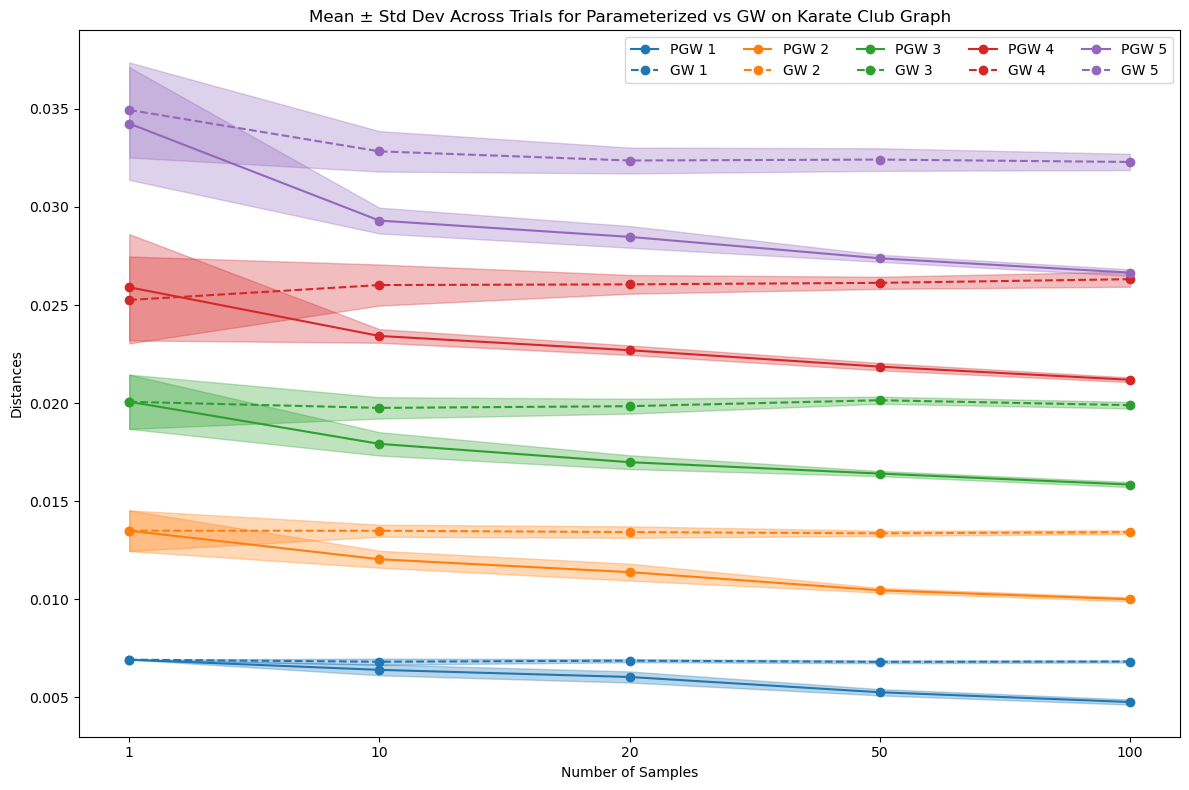

In [52]:
# Colormap for distinct colors
cmap = plt.get_cmap("tab10")
n_plots = len(all_scores_multiscale)
colors = [cmap(i) for i in range(n_plots)]

x = np.arange(len(all_scores_multiscale[0]))

plt.figure(figsize=(12, 8))
for idx, (scores_ms, scores_gw) in enumerate(zip(all_scores_multiscale, all_scores_gw)):
    # Compute statistics
    means_ms = np.array([np.mean(s) for s in scores_ms])
    stds_ms = np.array([np.std(s) for s in scores_ms])
    means_gw = np.array([np.mean(s) for s in scores_gw])
    stds_gw = np.array([np.std(s) for s in scores_gw])

    color = colors[idx]
    # Multi-scale: solid
    plt.plot(x, means_ms, "o-", color=color, label=f"PGW {idx+1}")
    plt.fill_between(x, means_ms - stds_ms, means_ms + stds_ms, alpha=0.3, color=color)
    # GW: dashed
    plt.plot(x, means_gw, "o--", color=color, label=f"GW {idx+1}")
    plt.fill_between(x, means_gw - stds_gw, means_gw + stds_gw, alpha=0.3, color=color)

plt.xlabel("Number of Samples")
# plt.xticks(x, [10, 20, 50, 100, 150])
plt.xticks(x, ns)
plt.ylabel("Distances")
plt.title("Mean ± Std Dev Across Trials for Parameterized vs GW on Karate Club Graph")
plt.legend(ncol=5)
plt.tight_layout()
plt.savefig(Path(folder_figs, "KarateClubGraph.pdf"), dpi=300)
plt.show()

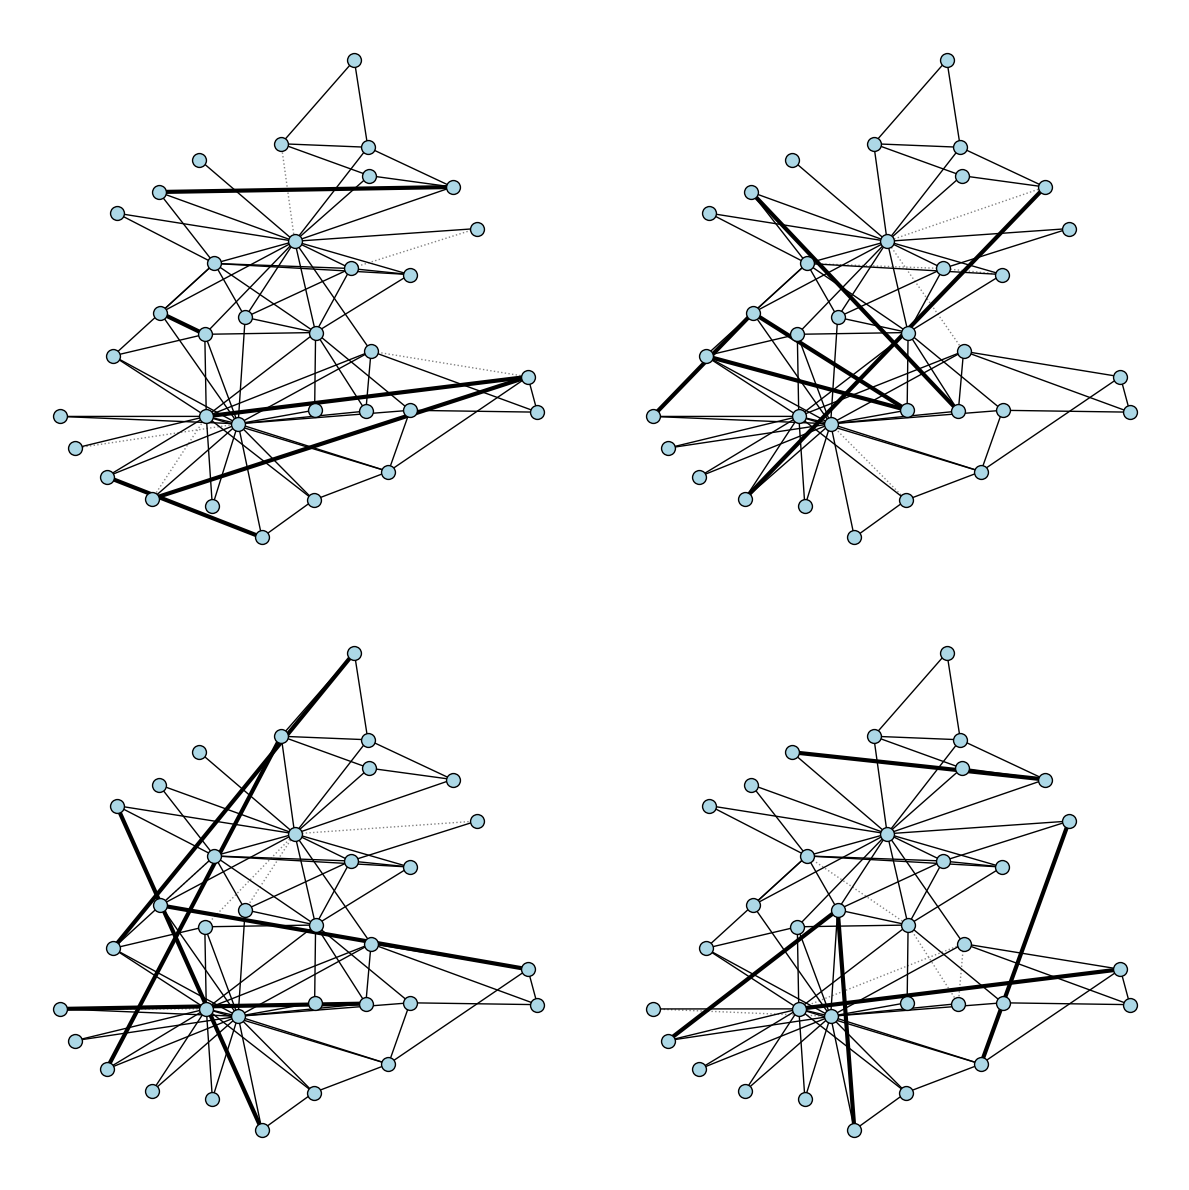

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
seeds = [0, 1, 2, 3]  # for reproducibility

for idx, seed in enumerate(seeds):
    ax = axes[idx]
    Gi = perturb_graph_edges(G, k=5, m=5, seed=seed)

    # Original and new edge sets (undirected, sorted tuples)
    orig_edges = {tuple(sorted(e)) for e in G.edges()}
    new_edges = {tuple(sorted(e)) for e in Gi.edges()}

    deleted = list(orig_edges - new_edges)
    added = list(new_edges - orig_edges)
    common = list(orig_edges & new_edges)

    # 1) Plot deleted edges as dotted lines
    nx.draw_networkx_edges(
        G, pos, edgelist=deleted, style="dotted", edge_color="gray", ax=ax
    )

    # 2) Plot the edges that remain (common) as normal thin lines
    nx.draw_networkx_edges(Gi, pos, edgelist=common, edge_color="black", width=1, ax=ax)

    # 3) Plot added edges as thicker lines
    nx.draw_networkx_edges(Gi, pos, edgelist=added, edge_color="black", width=3, ax=ax)

    # 4) Draw nodes on top
    nx.draw_networkx_nodes(
        Gi, pos, node_size=100, node_color="lightblue", edgecolors="k", ax=ax
    )

    # ax.set_title(f'Perturbation {idx+1}')
    ax.axis("off")

plt.tight_layout()
plt.show()

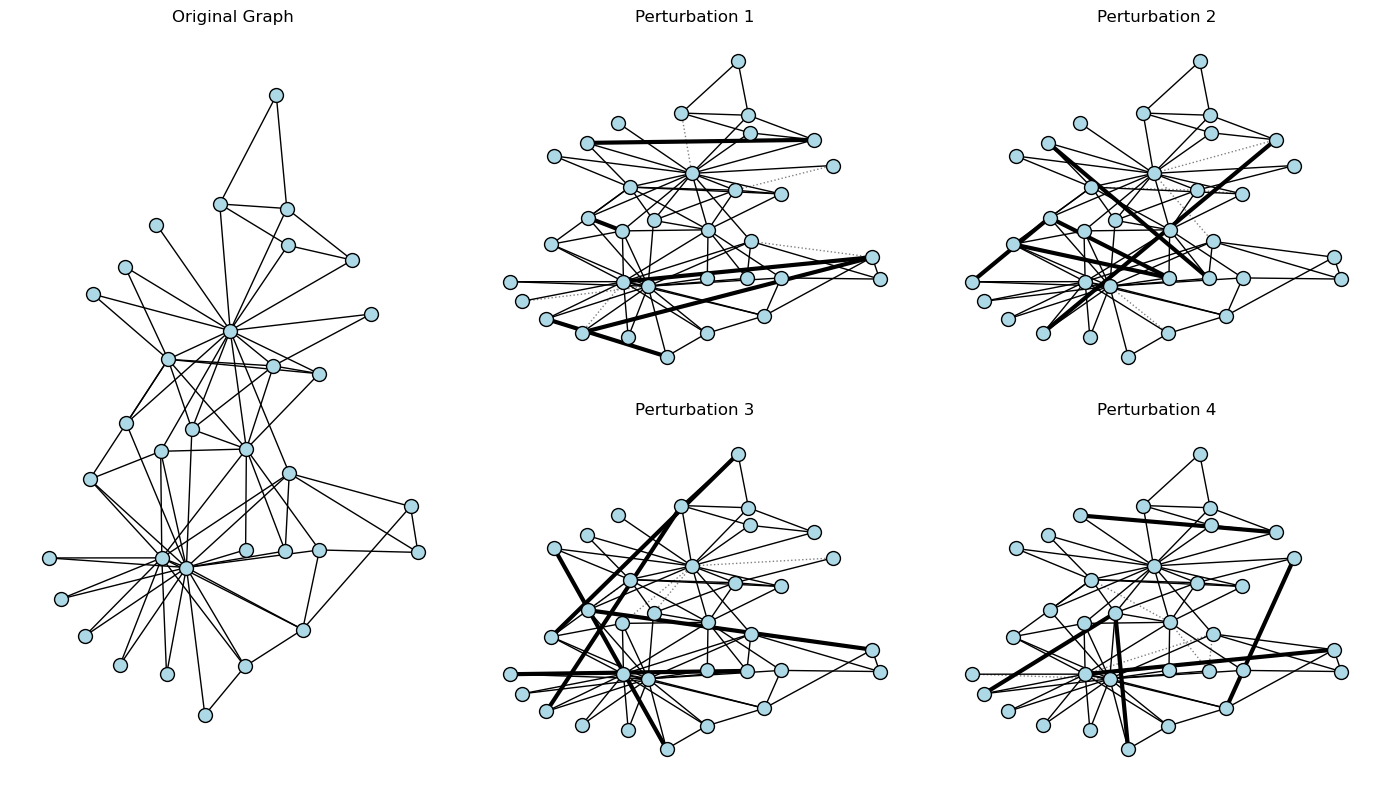

In [54]:
# Create a figure with 2 rows x 3 columns, left column for original spanning both rows
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1])

# 1) Plot original graph on the left (spanning both rows)
ax_orig = fig.add_subplot(gs[:, 0])
orig_edges = list(G.edges())
nx.draw_networkx_edges(
    G, pos, edgelist=orig_edges, edge_color="black", width=1, ax=ax_orig
)
nx.draw_networkx_nodes(
    G, pos, node_size=100, node_color="lightblue", edgecolors="k", ax=ax_orig
)
ax_orig.set_title("Original Graph")
ax_orig.axis("off")

# 2) Generate and plot 4 perturbed versions
seeds = [0, 1, 2, 3]
for idx, seed in enumerate(seeds):
    ax = fig.add_subplot(gs[idx // 2, (idx % 2) + 1])
    Gi = perturb_graph_edges(G, k=5, m=5, seed=seed)

    orig_set = {tuple(sorted(e)) for e in G.edges()}
    new_set = {tuple(sorted(e)) for e in Gi.edges()}

    deleted = list(orig_set - new_set)
    common = list(orig_set & new_set)
    added = list(new_set - orig_set)

    # Deleted edges: dotted gray
    nx.draw_networkx_edges(
        G, pos, edgelist=deleted, style="dotted", edge_color="gray", ax=ax
    )
    # Common edges: thin black
    nx.draw_networkx_edges(Gi, pos, edgelist=common, edge_color="black", width=1, ax=ax)
    # Added edges: thicker black
    nx.draw_networkx_edges(Gi, pos, edgelist=added, edge_color="black", width=3, ax=ax)
    # Nodes
    nx.draw_networkx_nodes(
        Gi, pos, node_size=100, node_color="lightblue", edgecolors="k", ax=ax
    )

    ax.set_title(f"Perturbation {idx + 1}")
    ax.axis("off")

plt.tight_layout()
plt.savefig(Path(folder_figs, "RandomGraphModel_KarateClub.pdf"), dpi=300)
plt.show()

/tmp/ipykernel_138140/2217378813.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


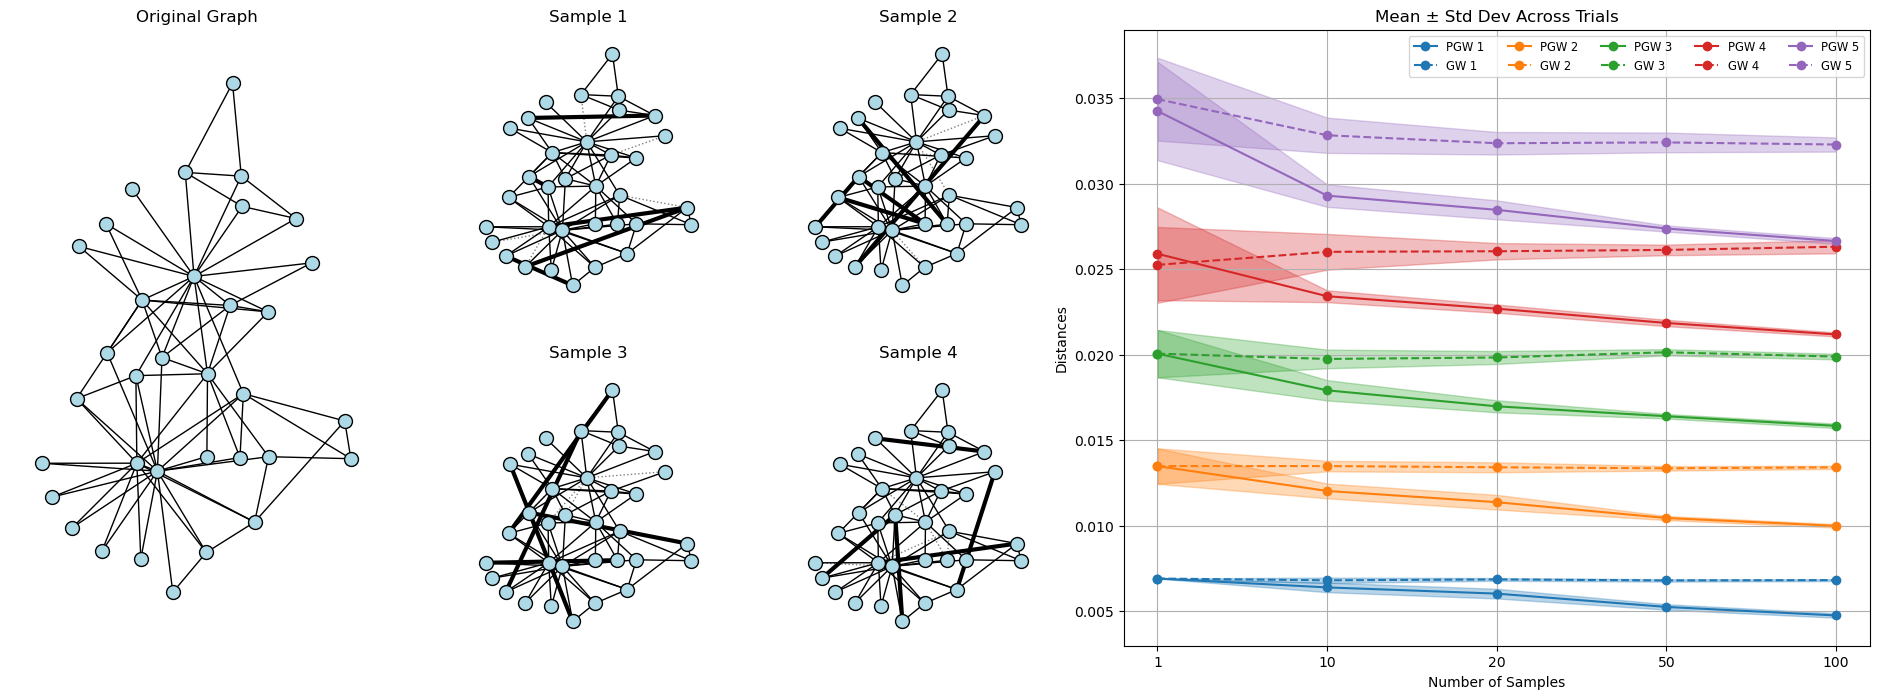

In [55]:
# Create figure with 2 rows, 4 columns (last column for scores)
fig = plt.figure(figsize=(24, 8))
gs = fig.add_gridspec(2, 4, width_ratios=[1.5, 1, 1, 3], wspace=0.2)

# 1) Original graph on left, spans both rows in column 0
ax0 = fig.add_subplot(gs[:, 0])
nx.draw_networkx_edges(
    G, pos, edgelist=list(G.edges()), edge_color="black", width=1, ax=ax0
)
nx.draw_networkx_nodes(
    G, pos, node_size=100, node_color="lightblue", edgecolors="k", ax=ax0
)
ax0.set_title("Original Graph")
ax0.axis("off")

# 2) Four perturbed graphs in columns 1 and 2
seeds = [0, 1, 2, 3]
for idx, seed in enumerate(seeds):
    row = idx // 2
    col = (idx % 2) + 1
    ax = fig.add_subplot(gs[row, col])
    Gi = perturb_graph_edges(G, k=5, m=5, seed=seed)

    orig_set = {tuple(sorted(e)) for e in G.edges()}
    new_set = {tuple(sorted(e)) for e in Gi.edges()}
    deleted = list(orig_set - new_set)
    common = list(orig_set & new_set)
    added = list(new_set - orig_set)

    # Deleted edges: dotted gray
    nx.draw_networkx_edges(
        G, pos, edgelist=deleted, style="dotted", edge_color="gray", ax=ax
    )
    # Common edges: thin black
    nx.draw_networkx_edges(Gi, pos, edgelist=common, edge_color="black", width=1, ax=ax)
    # Added edges: thick black
    nx.draw_networkx_edges(Gi, pos, edgelist=added, edge_color="black", width=3, ax=ax)
    # Nodes
    nx.draw_networkx_nodes(
        Gi, pos, node_size=100, node_color="lightblue", edgecolors="k", ax=ax
    )

    ax.set_title(f"Sample {idx+1}")
    ax.axis("off")

# 3) Scores plot in column 3 spanning both rows
ax_scores = fig.add_subplot(gs[:, 3])
cmap = plt.get_cmap("tab10")
n_plots = len(all_scores_multiscale)
colors = [cmap(i) for i in range(n_plots)]
x = np.arange(len(all_scores_multiscale[0]))

for idx, (scores_ms, scores_gw) in enumerate(zip(all_scores_multiscale, all_scores_gw)):
    # Compute mean and std
    means_ms = np.array([np.mean(s) for s in scores_ms])
    stds_ms = np.array([np.std(s) for s in scores_ms])
    means_gw = np.array([np.mean(s) for s in scores_gw])
    stds_gw = np.array([np.std(s) for s in scores_gw])

    color = colors[idx]
    # Multi-scale: solid + shaded
    ax_scores.plot(x, means_ms, "o-", color=color, label=f"PGW {idx+1}")
    ax_scores.fill_between(
        x, means_ms - stds_ms, means_ms + stds_ms, alpha=0.3, color=color
    )
    # GW: dashed + shaded
    ax_scores.plot(x, means_gw, "o--", color=color, label=f"GW {idx+1}")
    ax_scores.fill_between(
        x, means_gw - stds_gw, means_gw + stds_gw, alpha=0.3, color=color
    )

ax_scores.set_xlabel("Number of Samples")
# ax_scores.set_xticks(x, [10, 20, 50, 100, 150])
ax_scores.set_xticks(x, ns)
ax_scores.set_ylabel("Distances")
ax_scores.set_title("Mean ± Std Dev Across Trials")
ax_scores.legend(ncol=n_plots, fontsize="small")
ax_scores.grid(True)

plt.tight_layout()
plt.savefig(
    Path(folder_figs, "SummaryFigure_KarateClub.pdf"),
    dpi=300,
    bbox_inches="tight",  # crop to the figure’s contents
    pad_inches=0.1,
)
plt.show()